In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
gromacs_datapath="/content/drive/MyDrive/data/GROMACS/gromacs_sims"

Mounted at /content/drive


In [2]:
!pip install MDAnalysis
!pip install scienceplots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.4 MB/s eta 0:00:00


In [1]:
gromacs_datapath="."

## RMSD, Rg and NHB Data Gather

In [ ]:
%%time
import MDAnalysis as mda
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from MDAnalysis.analysis import rms

# Make sure you import matplotlib.pyplot
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

proteins={'colpk':{'name':'Colpk', 'abbrv':'colpk'},\
          'colpm':{'name':'Colpm', 'abbrv':'colpm'}}
ligands = {'pyc':{'name':'pyocyanin', 'abbrv':'pyc'},\
           'pea':{'name':'phosphatedylethanolamine', 'abbrv':'pea'},\
           'pgl':{'name':'phosphatedylglycerol', 'abbrv':'pgl'}}
dataframes = []
for protein_key, protein_value in proteins.items():
  for ligand_key, ligand_value in ligands.items():
    datadir = os.path.join(gromacs_datapath, protein_value['name'] + '_' + ligand_value['name'])
    mdname =  protein_value['abbrv']+'_'+ligand_value['abbrv']+'_complex'
    print("Running Analysis for complex ",mdname)
    raw_data = os.path.join(datadir,mdname,'sys_prod')
    xtcfile = os.path.join(raw_data,'prod_' + mdname+'_compact_compact.xtc')
    pdbfile = os.path.join(raw_data, 'start.pdb')
    print("Loading Trajectory ...")
    uni = mda.Universe(pdbfile, xtcfile)

    print("Calculating RMSD ...")
    R = rms.RMSD(uni,  # universe to align
    uni,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    rmsd_table = np.vstack((R.results.rmsd[:,1],R.results.rmsd[:,2])).T

    print("Calculating Rgyr ...")
    group = uni.select_atoms('protein')		# change the atom selection for your specific system
    times = []
    Rgyr = []
    for ts in tqdm(uni.trajectory):
      times.append(uni.trajectory.time)
      Rgyr.append(group.radius_of_gyration())
    Rgyrc_table = np.vstack((times, Rgyr)).T

    print("Calculating RMSF ...")
    c_alphas_c = uni.select_atoms('backbone and name CA')
    R_c = rms.RMSF(c_alphas_c).run(verbose=False)
    rmsf_table = np.vstack((c_alphas_c.resids, R_c.results.rmsf)).T

    print("Combining Data ...")
    # Create separate DataFrames for each calculation
    df_rmsd = pd.DataFrame(rmsd_table, columns=['RMSD_Time', 'RMSD_Value'])
    df_rgyr = pd.DataFrame(Rgyrc_table, columns=['Rgyr_Time', 'Rgyr_Value'])
    df_rmsf = pd.DataFrame(rmsf_table, columns=['Resids','RMSF_Value'])

    # Merge DataFrames based on appropriate criteria
    # Assuming you want RMSD and Rgyr data for each frame
    df = pd.merge(df_rmsd, df_rgyr, left_index=True, right_index=True)

    # Add RMSF data (may require adjustment based on desired relationship)
    df = pd.concat([df, df_rmsf], axis=1)
    # Alternatively, you might want to merge based on residue numbers
    # or repeat RMSF valdfues for each frame if necessary.

    df['Protein_Ligand'] = protein_value['abbrv']+'-'+ligand_value['abbrv']
    dataframes.append(df)

Running Analysis for complex  colpk_pyc_complex
Loading Trajectory ...


/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Calculating RMSD ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating Rgyr ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating RMSF ...
Combining Data ...
Running Analysis for complex  colpk_pea_complex
Loading Trajectory ...


/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Calculating RMSD ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating Rgyr ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating RMSF ...
Combining Data ...
Running Analysis for complex  colpk_pgl_complex
Loading Trajectory ...


/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Calculating RMSD ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating Rgyr ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating RMSF ...
Combining Data ...
Running Analysis for complex  colpm_pyc_complex
Loading Trajectory ...


/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Calculating RMSD ...


  0%|          | 0/10001 [00:00<?, ?it/s]

Calculating Rgyr ...


  0%|          | 0/10001 [00:00<?, ?it/s]

Calculating RMSF ...
Combining Data ...
Running Analysis for complex  colpm_pea_complex
Loading Trajectory ...


/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)


Calculating RMSD ...


  0%|          | 0/10001 [00:00<?, ?it/s]

Calculating Rgyr ...


  0%|          | 0/10001 [00:00<?, ?it/s]

Calculating RMSF ...
Combining Data ...
Running Analysis for complex  colpm_pgl_complex
Loading Trajectory ...


/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Calculating RMSD ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating Rgyr ...


  0%|          | 0/5001 [00:00<?, ?it/s]

Calculating RMSF ...
Combining Data ...
CPU times: user 42min 33s, sys: 2min, total: 44min 34s
Wall time: 1h 15min 52s


In [ ]:
# prompt: Dump all the dataframes into a single archive

import os
import zipfile

# Define the archive name
archive_name = 'dataframes.zip'

# Create a zip archive
with zipfile.ZipFile(archive_name, 'w') as zipf:
  for i, df in enumerate(dataframes):
    # Save each DataFrame to a temporary CSV file
    temp_csv_filename = f'dataframe_{i}.csv'
    df.to_csv(temp_csv_filename, index=False)

    # Add the CSV file to the zip archive
    zipf.write(temp_csv_filename)

    # Remove the temporary CSV file
    os.remove(temp_csv_filename)

print(f"DataFrames saved to {archive_name}")


DataFrames saved to dataframes.zip


In [3]:
# prompt: Load dataframes.zip from disk, unzip and load the contents of each csv file into a separate dataframe, each of which is a list member

import pandas as pd
import zipfile
import os

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/dataframes.zip'

# Create an empty list to store the dataframes
dataframes = []

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  # Iterate over the files in the zip archive
  for file_info in zip_ref.infolist():
    # Check if the file is a CSV file
    if file_info.filename.endswith('.csv'):
      # Extract the file to a temporary location
      with zip_ref.open(file_info) as csv_file:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file)
        # Append the DataFrame to the list
        dataframes.append(df)

# Now the 'dataframes' list contains all the DataFrames from the zip file
# You can access each DataFrame using its index in the list, e.g., dataframes[0], dataframes[1], etc.
print(f"Loaded {len(dataframes)} dataframes.")

# Example: Print the first few rows of the first DataFrame
if dataframes:
  print(dataframes[0].head())


Loaded 6 dataframes.
   RMSD_Time    RMSD_Value  Rgyr_Time  Rgyr_Value  Resids  RMSF_Value  \
0        0.0  5.479352e-07        0.0   27.810882     1.0   24.255485   
1       10.0  1.111426e+00       10.0   27.713305     2.0   22.877168   
2       20.0  1.487054e+00       20.0   27.820228     3.0   22.187847   
3       30.0  1.771388e+00       30.0   27.964083     4.0   20.682346   
4       40.0  1.729149e+00       40.0   27.754077     5.0   19.248122   

  Protein_Ligand  
0      colpk-pyc  
1      colpk-pyc  
2      colpk-pyc  
3      colpk-pyc  
4      colpk-pyc  


In [16]:
nhb_file='/content/drive/MyDrive/Colab Notebooks/nhbonds.tar.gz'

In [32]:
# prompt: untar the file in path nhb_file and load each of the constituent .npz files as into pandas dataframes. Each npz file has two numpu arrays, one for the time data and one for the number of hydrogen data. The file name is the name of the complex for which the data was prepared

import tarfile
import numpy as np
import pandas as pd
import os

# Extract the tar.gz file
with tarfile.open(nhb_file, 'r:gz') as tar:
    tar.extractall('/content')

# Directory where the .npz files are located after extraction
npz_dir = '/content'

# Create an empty dictionary to store the dataframes
nhb_dataframes = {}

# Loop through each file in the directory
for filename in os.listdir(os.path.join(npz_dir,'nhbonds')):
    if filename.endswith('.npz'):
        filepath = os.path.join(npz_dir, 'nhbonds',filename)
        # Load the .npz file
        try:
            with np.load(filepath) as data:
                # Extract the time and NHB data
                time = data['time']
                nhb = data['num_hbonds']

                # Create a pandas DataFrame
                df = pd.DataFrame({'Time': time, 'NHB': nhb})

                # Extract the complex name from the filename (assuming filename is 'complex_name.npz')
                complex_name = filename[:-4]  # Remove the '.npz' extension
                nhb_dataframes[complex_name] = df

        except Exception as e:
            print(f"Error loading file {filename}: {e}")

# Now nhb_dataframes dictionary contains the dataframes, keyed by complex name
# Access dataframes using the complex name, e.g., nhb_dataframes['colpk_pyc']


In [37]:
nhb_dataframes['colpm_pea_nhb']["NHB"]

pandas.core.series.Series

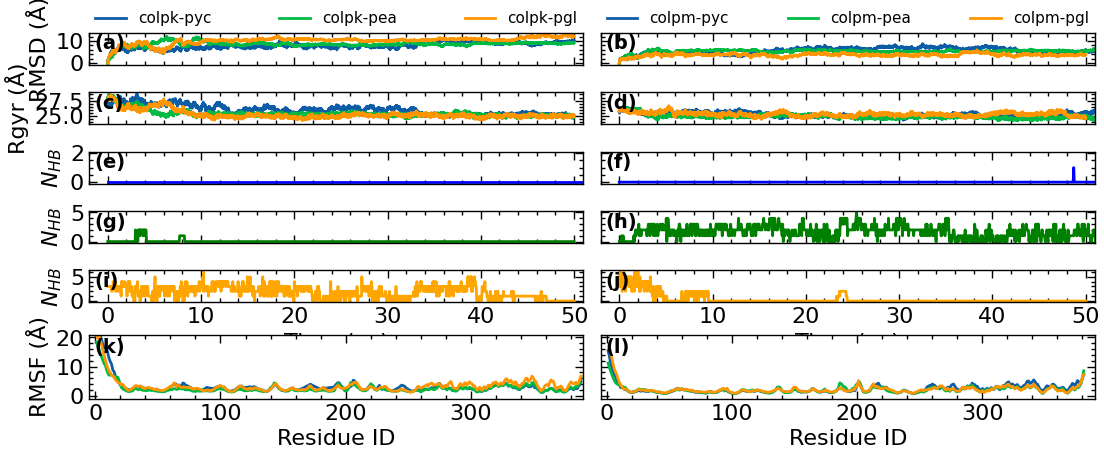

In [95]:
# prompt: use matplotlib to create a 3 X 2 panel figure. Panel 0,0 plots the RMSD values of colpk complexes vs time, panel 0,1 plots RMSD of colpm RMSD values, panels 1,0 and 1.1 does the same for Rgyr values, and Panels 2.0 and 2,1 plots RMSF versus resids. Rows 0 and 1 share x-axis.

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
# Assuming 'df' is your DataFrame and it's already loaded
# Replace with your actual DataFrame loading code

# Create a 3x2 panel figure
fig, axes = plt.subplots(5, 2, figsize=np.array([16, 9])*0.7, sharex=True, sharey='row')  # sharex for rows 0 and 1
rmsf1 = axes[-1, 0].inset_axes([0, -3, 1, 2]) # Adjust the geometry as needed
rmsf2 = axes[-1, -1].inset_axes([0, -3, 1, 2]) # Adjust the geometry as needed
rmsf2.set_yticklabels([])

# Iterate through the dataframes and plot the data
for i, df in enumerate(dataframes):
    protein_ligand = df['Protein_Ligand'].iloc[0]  # Assuming all rows have the same protein_ligand combination

    # Panel 0,0: RMSD vs Time for colpk
    if 'colpk' in protein_ligand:
        axes[0, 0].plot(df['RMSD_Time']/1000, df['RMSD_Value'], label=protein_ligand)

    # Panel 0,1: RMSD vs Time for colpm
    if 'colpm' in protein_ligand:
        axes[0, 1].plot(df['RMSD_Time']/1000, df['RMSD_Value'], label=protein_ligand)

    # Panel 1,0: Rgyr vs Time for colpk
    if 'colpk' in protein_ligand:
        axes[1, 0].plot(df['Rgyr_Time']/1000, df['Rgyr_Value'], label=protein_ligand)

    # Panel 1,1: Rgyr vs Time for colpm
    if 'colpm' in protein_ligand:
        axes[1, 1].plot(df['Rgyr_Time']/1000, df['Rgyr_Value'], label=protein_ligand)

    # Panel 2,0 & 2,1: RMSF vs Residues
    if 'colpk' in protein_ligand:
        rmsf1.plot(df['Resids'], df['RMSF_Value'], label=protein_ligand)
    if 'colpm' in protein_ligand:
        rmsf2.plot(df['Resids'], df['RMSF_Value'], label=protein_ligand)

axes[2,0].plot(nhb_dataframes['colpk_pyc_nhb']["Time"],nhb_dataframes['colpk_pyc_nhb']["NHB"], color='blue')
axes[3,0].plot(nhb_dataframes['colpk_pea_nhb']["Time"],nhb_dataframes['colpk_pea_nhb']["NHB"], color='green')
axes[4,0].plot(nhb_dataframes['colpk_pgl_nhb']["Time"],nhb_dataframes['colpk_pgl_nhb']["NHB"], color='orange')


axes[2,1].plot(nhb_dataframes['colpm_pyc_nhb']["Time"],nhb_dataframes['colpm_pyc_nhb']["NHB"], color='blue')
axes[3,1].plot(nhb_dataframes['colpm_pea_nhb']["Time"],nhb_dataframes['colpm_pea_nhb']["NHB"], color='green')
axes[4,1].plot(nhb_dataframes['colpm_pgl_nhb']["Time"],nhb_dataframes['colpm_pgl_nhb']["NHB"], color='orange')

axes[0, 0].set_ylabel('RMSD (Å)')
axes[1, 0].set_ylabel('Rgyr (Å)')
axes[2, 0].set_ylabel(r'$N_{HB}$')
axes[3, 0].set_ylabel(r'$N_{HB}$')
axes[4, 0].set_ylabel(r'$N_{HB}$')

axes[-1, 0].set_xlabel('Time (ns)')
axes[-1, 1].set_xlabel('Time (ns)')


for ax in (axes[0,0], axes[0,1]):
  l = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=3, mode="expand", borderaxespad=0.,prop = { "size": 11 })
  f = l.get_frame()
  f.set_linewidth(10)

rmsf1.set_xlabel('Residue ID')
rmsf1.set_ylabel('RMSF (Å)')
rmsf2.set_xlabel('Residue ID')

for i, ax in enumerate(axes.flat):
      ax.text(0.01, 0.95, "(" + chr(ord('a') + i) + ")", transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
      ax.set_xlim(-2, 51)
for i, ax in enumerate((rmsf1, rmsf2)):
  ax.set_ylim(-1,21)
  ax.set_xlim(-5,390)
  ax.set_yticks([0, 10, 20])
  ax.text(0.01, 0.95, "(" + chr(ord('k') + i) + ")", transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

plt.savefig("2025_02_06_time_series_rmsf.png", dpi=600)
plt.tight_layout()
plt.show()


In [1]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import MDAnalysis as mda
import numpy as np
import mdtraj as md

def do_hb(ligname,pdbfile, xtcfile, tprfile, stride = 3, verbose=True):
    # Load the trajectory using MDAnalysis to get the total number of frames
    u = mda.Universe(tprfile, xtcfile)
    total_frames = len(u.trajectory)
    total_time_ns = u.trajectory.totaltime / 1000  # Convert from ps to ns
    timestep = (stride / total_frames) * total_time_ns
    nframes = int(np.ceil(total_frames / stride))
    full_traj = md.load_xtc(xtcfile, stride=stride, top=pdbfile)
    lig_atoms = full_traj.topology.select(f'resname {ligname}')

    hbonds = md.baker_hubbard(full_traj, periodic=False, freq=0.01)
    label = lambda hbond : '%s - %s ... %s' % ( full_traj.topology.atom(hbond[0]),\
                                                full_traj.topology.atom(hbond[1]),\
                                                full_traj.topology.atom(hbond[2]))

    lig_hbonds = []
    for hbond in hbonds:
        d,h,a = hbond
        if d in lig_atoms or a in lig_atoms:
            lig_hbonds.append(hbond)
            if verbose:
                print(label(hbond))

    lig_hbonds = np.array(lig_hbonds)
    #Giving full tpr file to include bonding information
    complex_hbonds = []

    for hbond in lig_hbonds:
        d_ix, h_ix, a_ix = hbond
        complex_hbonds.append(HBA(
            universe=u,
            donors_sel=f"index {d_ix}",
            hydrogens_sel=f"index {h_ix}",
            acceptors_sel=f"index {a_ix}",
            update_selections=False
        ).run(verbose=verbose))
    return complex_hbonds

In [2]:
%%time
pdbfile='Colpm_pyocyanin/colpm_pyc_complex/sys_prod/start.pdb'
xtcfile='Colpm_pyocyanin/colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_compact_compact.xtc'
tprfile="Colpm_pyocyanin/colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex.tpr"

colpm_pyc_hb = do_hb('PYC',pdbfile, xtcfile, tprfile, stride=6)

ASN174-N - ASN174-H ... PYC382-O
ASN174-N - ASN174-H ... PYC382-N1
THR177-OG1 - THR177-HG1 ... PYC382-O


  0%|          | 0/10001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2595, and Acceptor, index 5795.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2595, and Acceptor, index 5795.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2595, and Acceptor, index 5797.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2595, and Acceptor, index 5797.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2645, and Acceptor, index 5795.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2645, and Acceptor, index 5795.
  warnings.warn(


CPU times: user 17min 4s, sys: 25.1 s, total: 17min 29s
Wall time: 17min 47s


In [3]:
import pickle
filename = 'colpm_pyc_hbdata.pkl'
with open(filename, 'wb') as file:
    pickle.dump(colpm_pyc_hb, file)

In [8]:
import MDAnalysis as mda
pdbfile='Colpm_pyocyanin/colpm_pyc_complex/sys_prod/start.pdb'
xtcfile='Colpm_pyocyanin/colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_compact_compact.xtc'
tprfile="Colpm_pyocyanin/colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex.tpr"

u = mda.Universe(tprfile, xtcfile)

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/coordinates/XDR.py:242: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [4]:
import pickle
import multiprocessing
import numpy as np

filename = 'colpm_pyc_hbdata.pkl'
with open(filename, 'rb') as file:
    colpm_pyc_hbonds = pickle.load(file)

tau_max = 200
intermittency = 20
hbond_lifetimes = []
labels = [] # for plotting
def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
        intermittency=intermittency
    )
    return hbond.count_by_type(), np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
pool = multiprocessing.Pool(3)
colpm_pyc_hbl = pool.map(calculate_lifetime, colpm_pyc_hbonds)
pool.close()
pool.join()

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/lib/_distopia.py:45: RuntimeWarning: Install 'distopia>=0.2.0,<0.3.0' to be used with this release of MDAnalysis. Your installed version of distopia >=0.3.0 will NOT be used.
  warnings.warn(


In [5]:
import pickle
import multiprocessing
import numpy as np

filename = 'colpm_pgl_hbdata.pkl'
with open(filename, 'rb') as file:
    colpm_pgl_hbonds = pickle.load(file)

tau_max = 200
intermittency = 20
hbond_lifetimes = []
labels = [] # for plotting
def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
        intermittency=intermittency
    )
    return hbond.count_by_type(), np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
pool = multiprocessing.Pool(3)
colpm_pgl_hbl = pool.map(calculate_lifetime, colpm_pgl_hbonds)
pool.close()
pool.join()

In [6]:
import pickle
import multiprocessing
import numpy as np

filename = 'colpm_pea_hbdata.pkl'
with open(filename, 'rb') as file:
    colpm_pea_hbonds = pickle.load(file)

tau_max = 200
intermittency = 20
hbond_lifetimes = []
labels = [] # for plotting
def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
        intermittency=intermittency
    )
    return hbond.count_by_type(), np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
pool = multiprocessing.Pool(3)
colpm_pea_hbl = pool.map(calculate_lifetime, colpm_pea_hbonds)
pool.close()
pool.join()

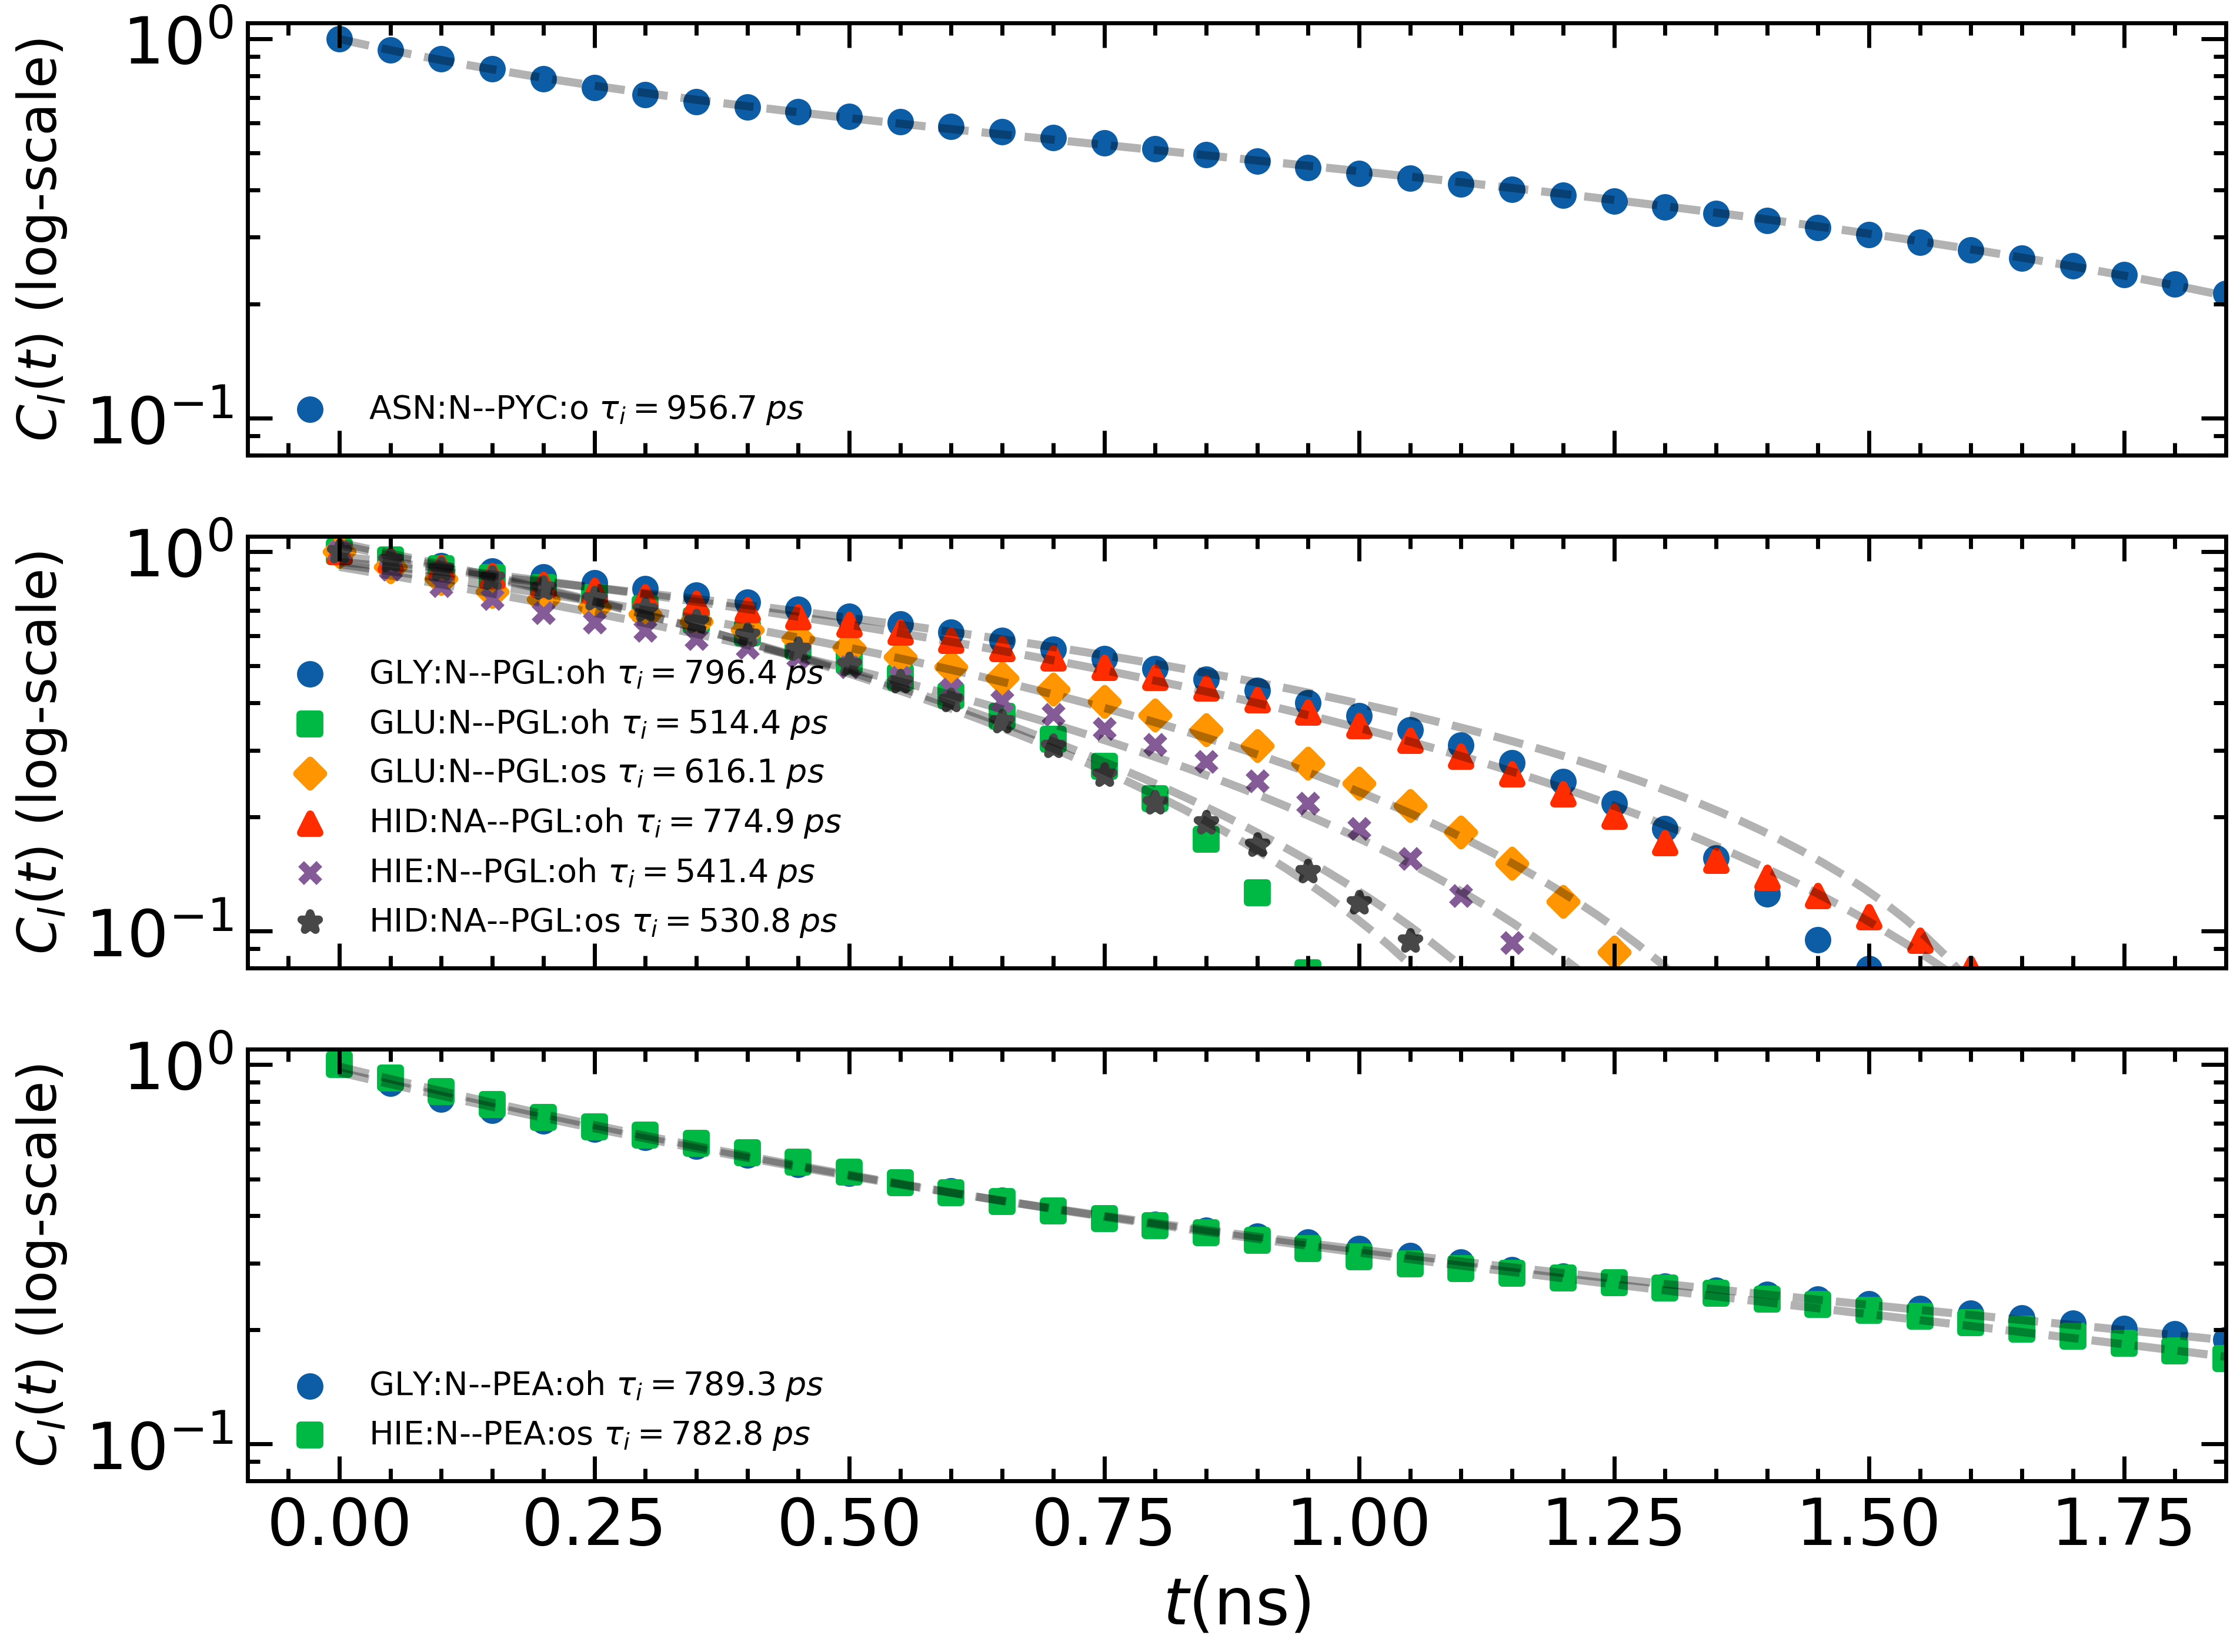

In [25]:
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scienceplots
import MDAnalysis as mda

plt.style.use(['science','notebook'])

stride = 5
# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2, A3, tau3):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2) + A3 * np.exp(-x/tau3)

symbols = ['o', 's', 'D', '^', 'x', '*', 'v', 'p', 'h', 'P', 'd', '>']  # List of symbols to cycle through

fig, axs = plt.subplots(3, 1, sharex=True)
#fig.suptitle("Hydrogen Bond lifetimes: Intermittency = 0.2 ns")

# Plot the lifetimes
i = 0
for hbond, hbl in colpm_pyc_hbl:
    d, a, _ = hbond.flatten()
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    try:
        popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30], maxfev=18000)
        fit_times = np.linspace(times[0], times[-1], 100)
        fit_hbl = hbond_corr(fit_times, *popt)
        tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
        tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
        if tau_i_ps > 500:
            axs[0].plot(fit_times, fit_hbl, color='black', ls='--', lw=2, alpha=0.3)
            axs[0].scatter(times[::stride], hbl[::stride], label= f'{d}--{a}' + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20, marker=symbols[i])
    except RuntimeError as e:
        print(f"Exception: {e}")
        axs[0].scatter(times[::stride], hbl[::stride], lw=2, s=20, marker=symbols[i])
        i = i + 1
        continue

# Plot the lifetimes
i = 0
for hbond, hbl in colpm_pgl_hbl:
    d, a, _ = hbond.flatten()
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    try:
        popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30], maxfev=18000)
        fit_times = np.linspace(times[0], times[-1], 100)
        fit_hbl = hbond_corr(fit_times, *popt)
        tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
        tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
        if tau_i_ps > 500:
            axs[1].plot(fit_times, fit_hbl, color='black', ls='--', lw=2, alpha=0.3)
            axs[1].scatter(times[::stride], hbl[::stride], label= f'{d}--{a}' + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20,marker=symbols[i])
            i = i + 1
    except RuntimeError as e:
        print(f"Exception: {e}")
        axs[1].scatter(times[::stride], hbl[::stride], lw=2, s=20,marker=symbols[i])
        i = i+1
        continue

# Plot the lifetimes
i = 0
for hbond, hbl in colpm_pea_hbl:
    d, a, _ = hbond.flatten()
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    try:
        popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30], maxfev=25000)
        fit_times = np.linspace(times[0], times[-1], 100)
        fit_hbl = hbond_corr(fit_times, *popt)
        tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
        tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
        if tau_i_ps > 500:
            axs[2].plot(fit_times, fit_hbl, color='black', ls='--', lw=2, alpha=0.3)
            axs[2].scatter(times[::stride], hbl[::stride], label= f'{d}--{a}' + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20,marker=symbols[i])
            i = i+1    
    except RuntimeError as e:
        print(f"Exception: {e}")
        axs[2].scatter(times[::stride], hbl[::stride], lw=2, s=20,marker=symbols[i])
        i = i+1
        continue


axs[-1].set_xlabel(r"$t \rm (ns)$")

for ax in axs:
    ax.set_ylabel(r"$C_I(t)$ (log-scale)", fontsize=13)
    ax.set_yscale("log")
    ax.legend(ncol=1, loc="lower left", prop={'size': 8})
    ax.set_ylim(0.08, 1.1)
    ax.set_xlim(-0.09, 1.85)

plt.savefig('hbonds_hbl_colpm.png', dpi=600)
plt.show()